**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 4 and 5: Assignment (225 points + 30 bonus points)*  
Author: Umut

# To Do

1. Move to my structure

In [1]:
# Group number: 17
# Sameera Sandaruwan, s1014012
# Student 2 name, student 2 number: ...
# Student 3 name, student 3 number: ...

https://github.com/basameera/NIPS_week_4_5

In [1]:
from chainer import ChainList, optimizers, serializers
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np
import cupy

---
# Dataset

![alt text](http://i64.tinypic.com/3rkzq.jpg)

---


**WaveNet component (75 points)**

* Implement missing parts of the call method (y and z). **25 points**
* Implement residual block class. **50 points**

---
Reminder:

* One convolution layer that has 61 kernels of size 2 with no nonlinearities.
![alt text](http://i67.tinypic.com/21mgi2w.png)
![alt text](http://i67.tinypic.com/292n04y.png)
---



# Contributor - Sameera

In [2]:
class _ResidualBlock(ChainList):
    def __init__(self, dilate):
        super(_ResidualBlock, self).__init__(L.DilatedConvolution2D(61, 122, (1, 2), dilate = dilate),
                                             L.Convolution2D(61, 573, 1))

    def __call__(self, x):
        y = F.split_axis(self[0](F.pad(x, ((0, 0), (0, 0), (0, 0), (self[0].dilate[1], 0)), 'constant')), 2, 1)
        y = F.split_axis(self[1](F.sigmoid(y[0]) * F.tanh(y[1])), (61,), 1)

        return x + y[0], y[1]

    
class _WaveNet(ChainList):
    def __init__(self):
        links = (L.Convolution2D(in_channels=61, out_channels=61, ksize=(1, 2)),)
        links += tuple(_ResidualBlock((1, 2 ** (i % 6))) for i in range(6))
        links += (L.Convolution2D(512, 512, 1), L.Convolution2D(512, 3843, 1))
        super(_WaveNet, self).__init__(*links)
        '''
        QUESTIONS
        1. Why/how conv2D_7 has input of 512? If 512, should the last Res. layer has output of 512
        2. Why/How 61*61 and 2*61 comes about?
        '''
        ''' --- Structure --- (in > out)
        0.conv2D (61 -> 61)
        1.Residual (61 > 61, 512)
        2.Residual (61 > 61, 512)
        3.Residual (61 > 61, 512)
        4.Residual (61 > 61, 512)
        5.Residual (61 > 61, 512)
        6.Residual (61 > 61, 512)
        7.conv2D (512 > 512)
        8.conv2D (512 > 3843)
        '''
    # check shape sizes
    def __call__(self, x):
        y = (self[0](F.pad(x, ((0, 0), (0, 0), (0, 0), (1, 0)), 'constant')),)
        z = 0

        for i in range(1, len(self) - 2):
            y = self[i](y[0])
            z += y[1]

        y, z = F.split_axis(self[-1](F.relu(self[-2](z))) , (3721,), 1)

        return F.reshape(y, (y.shape[0], 61, 61, y.shape[3])), F.reshape(z, (z.shape[0], 2, 61, z.shape[3]))

---

Reminder:

![alt text](http://i68.tinypic.com/sy6mix.png)

---

**CRF-RNN component (50 points)**

* Implement missing parts of the call method (z). **25 points**
* Why is z not normalized in the last iteration? **25 points**



# Contributor - Jitendra

### https://en.wikipedia.org/wiki/Conditional_random_field

In [3]:
'''
CRF - Conditional random field
This class calculate Mean-field approximation
'''
class _CRF(ChainList):
    def __init__(self):
        super(_CRF, self).__init__(L.ConvolutionND(1, 2, 2, 1, nobias = True))

    def __call__(self, x, y):
        z = F.softmax(-y)

        for i in range(5):
            z = -y - self[0](F.batch_matmul(z, x))

            if i < 4:
                z = F.softmax(z)

        return z

**WaveCRF model (50 points)**

1. Implement missing parts of the call method (k, psi_u and Q_hat). **20 points**
2. Implement missing parts of the save and load methods (save and load model). **10 points**
3. Implement missing parts of the test and train methods (forward and/or backward propagate). **20 points**

# Contributor - Mohit

In [4]:
class WaveCRF(object):
    def __init__(self):
        self.log = {('test', 'accuracy'): (), ('test', 'loss'): (), ('training', 'accuracy'): (),
                    ('training', 'loss'): ()}
        self.model = ChainList(_WaveNet(), _CRF())
        self.optimizer = optimizers.Adam(0.0002, 0.5)

        self.optimizer.setup(self.model)

    def __call__(self, x):
        k, psi_u = self.model[0](x)
        Q_hat = self.model[1](F.reshape(F.transpose(k, (0, 3, 1, 2)), (-1, 61, 61)),
                              F.reshape(F.transpose(psi_u, (0, 3, 1, 2)), (-1, 2, 61)))

        return F.transpose(F.reshape(Q_hat, (x.shape[0], x.shape[3], 2, 61)), (0, 2, 3, 1))

    @classmethod
    def load(cls, directory):
        self = cls()
        self.log = np.load('{}/log.npy'.format(directory))

        serializers.load_npz('{}/model.npz'.format(directory), self.model)
        serializers.load_npz('{}/optimizer.npz'.format(directory), self.optimizer)

        return self

    def save(self, directory):
        np.save('{}/log.npy'.format(directory), self.log)
        serializers.save_npz('{}/model.npz'.format(directory), self.model)
        serializers.save_npz('{}/optimizer.npz'.format(directory), self.optimizer)

    def test(self, Q, x):
        with chainer.using_config('train', False):
            Q_hat = self(x)
            loss = F.softmax_cross_entropy(Q_hat, Q)

            self.log['test', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
            self.log['test', 'loss'] += (float(loss.data),)

    def train(self, Q, x):
        Q_hat = self(x)
        loss = F.softmax_cross_entropy(Q_hat, Q)

        self.model.cleargrads()
        loss.backward()
        self.optimizer.update()

        self.log['training', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
        self.log['training', 'loss'] += (float(loss.data),)

# Training

In [5]:
%matplotlib inline

import IPython
import chainer
import matplotlib
import numpy
import os
import pickle
import random
import tqdm
import matplotlib.pyplot as plt

In [6]:
batch_size = 30
epochs = 50  #100
root = 'WaveNetModel'


song_id = 4 # change for each new test

In [7]:
with open('Data/piano_rolls.p', 'rb') as f:
    piano_rolls = pickle.load(f, encoding = 'latin1') #works

keys = sorted(piano_rolls.keys())

random.seed(6)
random.shuffle(keys)

test_set = dict((key, piano_rolls[key]) for key in keys[:int(0.1 * len(keys))])
training_set = dict((key, piano_rolls[key]) for key in keys[int(0.1 * len(keys)):])

training_set_keys = list(training_set.keys())
test_set_keys = list(test_set.keys())

print(len(test_set))
print(len(training_set))

363
3273


### Model Train

In [9]:
waveCRF = WaveCRF()
waveCRF.model.to_gpu()

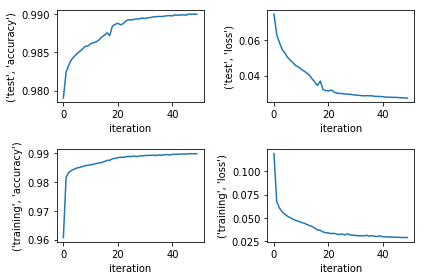


DONE...


In [10]:
for epoch in tqdm.tnrange(epochs, ascii=True, desc="NIPS-G17:"):
    random.shuffle(training_set_keys)

    batch = ()

    for key in tqdm.tqdm_notebook(training_set_keys, leave = False, desc='Train {}:'.format(epoch)):
        i = random.randint(0, training_set[key].shape[1] - 80)
        batch += (training_set[key][32 : 93, i : i + 80],)

        if len(batch) == batch_size:
            batch = waveCRF.model.xp.array(batch)

            waveCRF.train(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

            batch = ()

    for key in tqdm.tqdm_notebook(test_set, leave = False, desc='Val {}:'.format(epoch)):
        batch = waveCRF.model.xp.array((test_set[key][32 : 93],))

        waveCRF.test(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

    IPython.display.clear_output()

    for i, key in enumerate(waveCRF.log):
        matplotlib.pyplot.subplot(221 + i)
        matplotlib.pyplot.plot(numpy.array(waveCRF.log[key]).reshape(epoch + 1, -1).mean(1))
        matplotlib.pyplot.xlabel('iteration')
        matplotlib.pyplot.ylabel(key)

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    os.makedirs('{}/Models/WaveCRF_{}/{}'.format(root, song_id, epoch))
    waveCRF.save('{}/Models/WaveCRF_{}/{}'.format(root, song_id, epoch))

print("DONE...")

**Test (50 points)**  

* Generate a number of samples, pick the best one and play it in the notebook. **50 points**

# Music Generation Loop

## One Time Run

# ToDO : Prediction sampling methods

WaveNetModel/Models/WaveCRF_4/49


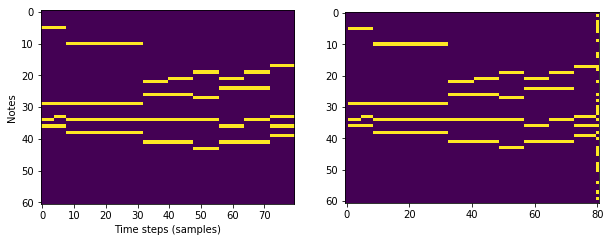

In [8]:
# Load model
model_dir = 'WaveNetModel/Models/WaveCRF_{}/{}'.format(song_id, epochs-1)
print(model_dir)
waveCRF_test = WaveCRF()
waveCRF_test.load(model_dir)
waveCRF_test.model.to_gpu()

#create a sample from the test set
batch = ()

for key in tqdm.tqdm_notebook(test_set_keys[:1], leave = False):
    i = random.randint(0, test_set[key].shape[1] - 80)
    Tsample = test_set[key][32 : 93, i : i + 80]
    batch += (Tsample,)

        
# print("---")
# print(batch)
batch = waveCRF_test.model.xp.array(batch)
# print(type(batch))
# print(batch.shape)
Xt = batch[:, :, None, :-1].astype('f')
Xt = F.pad(Xt, ((0, 0), (0, 0), (0, 0), (1, 0)), 'constant')
# print('1',Xt.shape)
# print('2',type(Xt))

# plot input song
input_song = cupy.asnumpy(batch[0])

# print(input_song.shape)
# print(type(input_song))
# print(input_song)

fig=plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(input_song)
plt.xlabel('Time steps (samples)')
plt.ylabel("Notes")

results_dir = 'Results'

np.savez('{}/input_song_{}.npz'.format(results_dir, song_id), input_song=input_song)


# prediction
prediction = F.softmax(waveCRF_test(Xt))

# decode prediction
new_note = prediction.data[:,:,:,-1] #slide out the predicted note - cupy.asnumpy()

# argmax
pred_notes = np.argmax(new_note, axis=1)>0

# add predicted note to the previous note
Yt = F.pad(Xt, ((0, 0), (0, 0), (0, 0), (0, 1)), 'constant')
Yt.data[:,:,:,-1] = pred_notes[0].astype('f').reshape(1, 61, 1)

# print('3',Yt.data.shape)

# prep next Xt
next_Xt = Yt.data>0
# print('4',type(next_Xt))
next_Xt_crop = cupy.asnumpy(next_Xt[0].transpose([1,0,2])[0,:,-80:])
# print('5',next_Xt_crop.shape)
batch = (next_Xt_crop,)

batch = waveCRF_test.model.xp.array(batch)
Xt = batch[:, :, None, :-1].astype('f')
Xt = F.pad(Xt, ((0, 0), (0, 0), (0, 0), (1, 0)), 'constant')
# print('6',Xt.shape)

newImg = cupy.asnumpy(Yt.data)
newImg = newImg.transpose([0, 2, 1, 3])
plt.subplot(122)
plt.imshow(newImg[0][0])

## Loop Code

(1, 61, 1, 129)


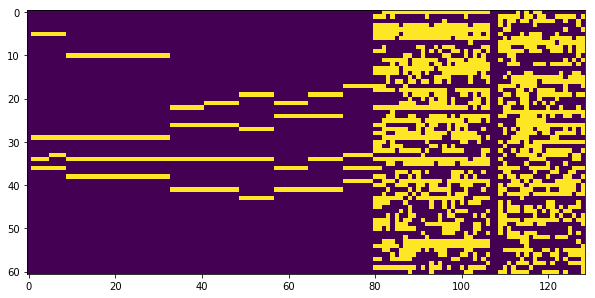

In [38]:
for _ in range(10):
    # prediction
    prediction = F.softmax(waveCRF_test(Xt))

    # decode prediction
    new_note = prediction.data[:,:,:,-1] #slide out the predicted note - cupy.asnumpy()
    # print(new_note)
    
    # argmax
    # pred_notes = np.argmax(new_note, axis=1)>0

    # Noraml
    new_note_arr = []
    for line in new_note[0].transpose():
        new_note_val = False
#         if np.random.uniform()<=line[0]:
        if np.random.random()<=line[0]:
            new_note_val = True
        new_note_arr.append(new_note_val)

    pred_notes = cupy.asarray(np.array(new_note_arr).reshape((61, 1)).transpose())

    # add predicted note to the previous note
    Yt = F.pad(Yt, ((0, 0), (0, 0), (0, 0), (0, 1)), 'constant')
    Yt.data[:,:,:,-1] = pred_notes[0].astype('f').reshape(1, 61, 1)

    # prep next Xt
    next_Xt = Yt.data>0
    next_Xt_crop = cupy.asnumpy(next_Xt[0].transpose([1,0,2])[0,:,-80:])
    batch = (next_Xt_crop,)

    batch = waveCRF_test.model.xp.array(batch)
    Xt = batch[:, :, None, :-1].astype('f')
    Xt = F.pad(Xt, ((0, 0), (0, 0), (0, 0), (1, 0)), 'constant')

print(Yt.data.shape)
newImg = cupy.asnumpy(Yt.data)
newImg = newImg.transpose([0, 2, 1, 3])[0][0]>0
fig=plt.figure(figsize=(10, 10))
plt.imshow(newImg)

# Saved file load test

(61, 101)


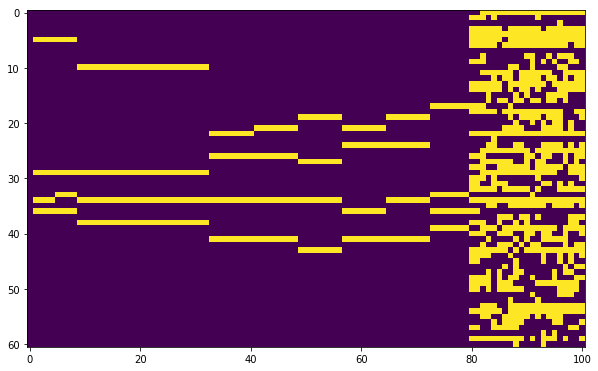

In [10]:
# Save the output song
np.savez('{}/output_song_{}.npz'.format(results_dir, song_id), newImg=newImg)
new_song = np.load('{}/output_song_{}.npz'.format(results_dir, song_id))
new_song = new_song[new_song.files[0]]

print(new_song.shape)
fig=plt.figure(figsize=(10, 10))
plt.imshow(new_song)

# ----------------------------------------------------------------------------------------------

**Bonus question (30 points)**

* Discuss how you can improve the model (you can talk about different architectures or different ways to encode the inputs, etc.) **10 points**
* Discuss the assumptions behind the meanfield approximation and its shortcomings. **10 points**
* Prove that the iterative update equation (CRF-RNN component) is differentiable so that we can backpropagate through them. **10 points**

# Notes
- During training, in CRF, last output should not be softmax output. But during test, it should be done.

In [19]:
# prediction sampling test
# print(new_note.shape)
# print(type(new_note))
# print(new_note[:,:,0])
# print(np.argmax(new_note, axis=1).shape)

# print(new_note[0].transpose())

# print(new_note[0,-1,-1])
# print(new_note)
# print(new_note.shape)
new_note_arr = []
for line in new_note[0].transpose():
    new_note_val = 0.0
    if np.random.random()<=line[0]:
        new_note_val = 1.0
    new_note_arr.append(new_note_val)
print(new_note[0].transpose()[0])
for x in range(len(new_note_arr)):
    print(new_note_arr[x], '\t=',new_note[0].transpose()[x][0])
# first line is ON and second OFF

[0.00124769 0.99875236]
0.0 	= 0.0012476936
1.0 	= 0.99994504
1.0 	= 0.95583874
0.0 	= 0.34873244
1.0 	= 0.044528753
0.0 	= 0.014057348
0.0 	= 0.06675507
1.0 	= 0.9911841
1.0 	= 0.99919444
1.0 	= 0.9817446
1.0 	= 0.9974462
1.0 	= 0.22361907
0.0 	= 0.023786101
0.0 	= 0.014043806
0.0 	= 0.05653867
0.0 	= 0.7709505
1.0 	= 0.96048105
1.0 	= 0.9892579
1.0 	= 0.24374567
0.0 	= 0.0473629
1.0 	= 0.9986681
0.0 	= 0.64859426
0.0 	= 0.17749085
1.0 	= 0.9999088
0.0 	= 0.010815904
1.0 	= 0.37661308
0.0 	= 0.24036908
1.0 	= 0.92053396
0.0 	= 0.10957973
0.0 	= 0.016157623
0.0 	= 0.23547913
1.0 	= 0.9815677
0.0 	= 0.052587397
1.0 	= 0.9830467
0.0 	= 0.23802917
0.0 	= 0.0047996175
1.0 	= 0.99984276
0.0 	= 0.47386453
1.0 	= 0.9295382
0.0 	= 4.22158e-05
0.0 	= 0.2198924
1.0 	= 0.8628529
0.0 	= 0.06172028
0.0 	= 0.16833943
0.0 	= 0.17836924
1.0 	= 0.99841547
0.0 	= 0.019653484
1.0 	= 0.9996915
0.0 	= 0.0034823946
1.0 	= 0.5065375
0.0 	= 0.5141658
1.0 	= 0.99448365
1.0 	= 0.94645685
0.0 	= 0.078859255
0.0 